In [1]:
import pandas as pd
import os

In [2]:
speeches = pd.read_parquet('src/Data/ecb-speeches.parquet')
releases = pd.read_csv("src/Data/ecb_releases_302.csv")
announcements = pd.read_csv("src/Data/policy_announcements.csv")

In [3]:
speeches

,date,content
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...
1,1998-09-18,Mr. Duisenberg’s opening statement at the meet...
2,1998-10-12,Mr. Duisenberg speaks on changes in European f...
3,1998-10-12,Mr. Duisenberg's statement to the European Par...
4,1998-10-22,Mr. Duisenberg’s opening statement at the pres...
...,...,...
2250,2022-02-15,Christine Lagarde: 20th anniversary of the ent...
2251,2022-02-17,Christine Lagarde: Introductory statement - Eu...
2252,2022-02-23,Frank Elderson: Prudential pathways to Paris C...
2253,2022-02-23,Frank Elderson: Towards an immersive superviso...


In [4]:
import pandas as pd

def descriptive_statistics_to_latex(df):
    # Extract year and month from 'date' column
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    
    # Frequency of speeches by month for each year
    monthly_count = df.groupby(['year', 'month']).size().unstack(fill_value=0)
    
    # Adding a column for yearly total
    monthly_count['Total'] = monthly_count.sum(axis=1)
    
    # Rename month columns for clarity
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_count.columns = month_names + ['Total']
    
    # Add a row for monthly total
    monthly_count.loc['Total', :] = monthly_count.sum(axis=0)
    
    # Convert the DataFrame to integer type
    monthly_count = monthly_count.astype(int)
    
    # Convert to LaTeX format
    latex_output = monthly_count.to_latex()

    return latex_output

# Assuming speeches is already defined
latex_table = descriptive_statistics_to_latex(speeches)
print(latex_table)


\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 & Jan & Feb & Mar & Apr & May & Jun & Jul & Aug & Sep & Oct & Nov & Dec & Total \\
year &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1998 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 3 & 2 & 1 & 8 \\
1999 & 4 & 2 & 4 & 1 & 6 & 5 & 3 & 0 & 4 & 7 & 7 & 3 & 46 \\
2000 & 3 & 2 & 4 & 3 & 5 & 3 & 3 & 0 & 6 & 7 & 7 & 2 & 45 \\
2001 & 3 & 4 & 3 & 1 & 6 & 4 & 2 & 0 & 5 & 3 & 5 & 0 & 36 \\
2002 & 5 & 4 & 5 & 4 & 5 & 2 & 3 & 0 & 3 & 5 & 2 & 2 & 40 \\
2003 & 1 & 3 & 2 & 3 & 3 & 3 & 3 & 0 & 2 & 3 & 4 & 4 & 31 \\
2004 & 2 & 6 & 1 & 8 & 7 & 5 & 2 & 1 & 5 & 7 & 6 & 6 & 56 \\
2005 & 2 & 5 & 6 & 6 & 4 & 10 & 2 & 1 & 3 & 4 & 3 & 5 & 51 \\
2006 & 3 & 3 & 5 & 5 & 10 & 6 & 5 & 2 & 1 & 6 & 6 & 6 & 58 \\
2007 & 3 & 4 & 4 & 7 & 7 & 11 & 6 & 3 & 7 & 14 & 10 & 12 & 88 \\
2008 & 14 & 9 & 10 & 17 & 12 & 11 & 10 & 2 & 21 & 13 & 16 & 14 & 149 \\
2009 & 11 & 11 & 11 & 11 & 4 & 20 & 8 & 2 & 16 & 9 & 17 & 10 & 130 \\
2010 & 7 & 6 & 12 & 16 & 11 & 16 & 6 & 1 & 8 & 18 & 13 & 7 & 1

In [5]:
import pandas as pd

def consolidate_lines(df):
    """
    Consolidate lines in the content of a dataframe.
    If a line does not end with a full stop, it is merged
    with the next line, removing unnecessary newline characters.

    Args:
        df (pandas.DataFrame): Dataframe with 'content' column

    Returns:
        pandas.DataFrame: Modified dataframe with consolidated lines
    """
    consolidated_data = []

    for index, row in df.iterrows():
        content = row['content']
        lines = content.split('\n')
        consolidated_content = ""
        for i, line in enumerate(lines):
            line = line.strip()
            if line and (line[-1] in ".!?" or i == len(lines) - 1):
                consolidated_content += line + " "  # Append a space after each line
            else:
                consolidated_content += line + " "  # Append a space to separate lines

        consolidated_row = row.copy()
        consolidated_row['content'] = consolidated_content.strip()
        consolidated_data.append(consolidated_row)

    # Create new dataframe with consolidated content
    new_df = pd.DataFrame(consolidated_data)

    return new_df



import re

def split_paragraphs(df):
    """
    Splits content of dataframe into separate rows. 
    If a paragraph exceeds 512 words, it is limited to 
    two nearly equal parts, with the split done at a full stop.
    
    Args:
        df (pandas.DataFrame): Dataframe with 'date' and 'content' columns
    
    Returns:
        pandas.DataFrame: Modified dataframe with split content
    """
    data = []

    for index, row in df.iterrows():
        date = row['date']
        content = row['content']

        # Split content into sentences
        sentences = re.split(r'(?<=[.!?])\s+', content)

        # Process each sentence
        current_part = ""
        for sentence in sentences:
            if len(current_part.split()) + len(sentence.split()) <= 350:
                current_part += " " + sentence
            else:
                if current_part.strip():
                    data.append([date, current_part.strip()])
                current_part = sentence

        # Append remaining part if exists
        if current_part.strip():
            data.append([date, current_part.strip()])

    # Create new dataframe
    new_df = pd.DataFrame(data, columns=['date', 'content'])

    return new_df



In [6]:
speeches_consolidated = consolidate_lines(speeches)
speeches_consolidated = split_paragraphs(speeches_consolidated)
speeches_consolidated

,date,content
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...
1,1998-07-17,"First, any “growth dividend” resulting from th..."
2,1998-07-17,The committees are as follows (listed in alpha...
3,1998-07-17,The Governing Council intends to decide on the...
4,1998-07-17,The Governing Council furthermore agreed that ...
...,...,...
19319,2022-02-23,"And finally, disclosure frameworks and taxonom..."
19320,2022-02-25,Frank Elderson: Towards a stronger Anti-Money ...
19321,2022-02-25,The risk of the use of the financial system fo...
19322,2022-02-25,This type of measure has so far only been impl...


In [7]:
# create counts column that counts words in content column of each row
speeches_consolidated['counts'] = speeches_consolidated['content'].str.split().str.len()

# remove observations with missing values and counts of less than 50
speeches_consolidated = speeches_consolidated[(speeches_consolidated['counts']>=20) & (speeches_consolidated['counts']<500)]

In [8]:
speeches_consolidated

,date,content,counts
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,340
1,1998-07-17,"First, any “growth dividend” resulting from th...",345
2,1998-07-17,The committees are as follows (listed in alpha...,344
3,1998-07-17,The Governing Council intends to decide on the...,321
4,1998-07-17,The Governing Council furthermore agreed that ...,347
...,...,...,...
19319,2022-02-23,"And finally, disclosure frameworks and taxonom...",307
19320,2022-02-25,Frank Elderson: Towards a stronger Anti-Money ...,313
19321,2022-02-25,The risk of the use of the financial system fo...,331
19322,2022-02-25,This type of measure has so far only been impl...,332


## Import Transformers


In [9]:
from transformers import AutoTokenizer

# Define the tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)




In [10]:
import nltk
nltk.download('punkt')
from transformers import pipeline

import transformers

classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased",
)


[nltk_data] Downloading package punkt to /home/ozodbek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-09-03 10:31:28.208583: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-03 10:31:31.069316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 10:31:38.619178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import pandas as pd
from functions import calculate_sentiment_distilbert

max_chunk_length = 512

# Create an empty DataFrame
df = pd.DataFrame()

# add content
df['content'] = speeches_consolidated['content'].head(10)

# Apply the sentiment analysis function to the 'content' column for the first 10 rows
df[['positive', 'negative']] = speeches_consolidated['content'].head(10).apply(
    lambda x: pd.Series(calculate_sentiment_distilbert(x))
)
# Print the updated DataFrame
print(df)


                                             content  positive  negative
0  Mr. Duisenberg reports on the outcome of the s...  0.988099  0.011901
1  The general picture is one of continued econom...  0.960844  0.039156
2  As far as pricedevelopments are concerned, inf...  0.997458  0.002542
3  Economic growth has been driven increasingly b...  0.787363  0.212637
4  The favourable conjunctural situation has star...  0.815906  0.184094
5  As regards monetary and financial developments...  0.687710  0.312290
6  In principle, the economic performance I have ...  0.531834  0.468166
7  In this respect, I should like to underline th...  0.998245  0.001755
8  Second, most Member States need togo a step fu...  0.928188  0.071812
9  This implies that the benchmark for fiscalpoli...  0.995707  0.004293


In [9]:
# Define the start and end dates of the desired date range
start_date = '2008-09-01'
end_date = '2008-09-30'

# Filter the DataFrame based on the date range
subset_df = speeches[(speeches['date'] >= start_date) & (speeches['date'] <= end_date)]

# Apply the sentiment analysis function to the 'content' column for the subset
subset_df[['positive', 'negative']] = subset_df['content'].apply(lambda x: pd.Series(calculate_sentiment_distilbert(x)))

# Print the updated subset DataFrame
print(subset_df)


          date                                            content  positive  \
544 2008-09-03  Gertrude Tumpel-Gugerell: Start of the ECB/ESC...  0.983223   
545 2008-09-04  Gertrude Tumpel-Gugerell: Moving ahead with th...  0.976558   
546 2008-09-09  European Central Bank: Press conference – intr...  0.903439   
547 2008-09-09  Jürgen Stark: Monetary policy during the finan...  0.945200   
548 2008-09-09  Jean-Claude Trichet: Risk and the macro-econom...  0.931020   
549 2008-09-09  José Manuel González-Páramo: Globalisation, ma...  0.932746   
550 2008-09-10  Jürgen Stark: Economic perspectives and moneta...  0.931714   
551 2008-09-10  Gertrude Tumpel-Gugerell: What is the role of ...  0.976124   
552 2008-09-11  José Manuel González-Páramo: Some lessons from...  0.939504   
553 2008-09-11  Jean Claude-Trichet: Hearing before the Econom...  0.889569   
554 2008-09-11  Gertrude Tumpel-Gugerell: SEPA for cards\nSpee...  0.900189   
555 2008-09-15  Gertrude Tumpel-Gugerell: EU priorit

/tmp/ipykernel_6673/2830050635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[['positive', 'negative']] = subset_df['content'].apply(lambda x: pd.Series(calculate_sentiment_distilbert(x)))
/tmp/ipykernel_6673/2830050635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[['positive', 'negative']] = subset_df['content'].apply(lambda x: pd.Series(calculate_sentiment_distilbert(x)))


# Speeches with FinBERT

In [10]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

In [11]:
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')


In [12]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

sentiment = pipe(text)
sentiment

/tmp/ipykernel_6673/1113428978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[['positive', 'negative']] = subset['content'].head(10).apply(lambda x: pd.Series(calculate_sentiment_finbert(x)))
/tmp/ipykernel_6673/1113428978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[['positive', 'negative']] = subset['content'].head(10).apply(lambda x: pd.Series(calculate_sentiment_finbert(x)))
/tmp/ipykernel_6673/1113428978.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,date,content,counts,positive,negative,neutral
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,50,0.937748,0.041710,0.020542
1,1998-07-17,The general picture is one of continued econom...,34,0.034190,0.034694,0.931116
2,1998-07-17,"As far as pricedevelopments are concerned, inf...",49,0.030530,0.951551,0.017919
3,1998-07-17,Economic growth has been driven increasingly b...,35,0.883557,0.097784,0.018659
4,1998-07-17,The favourable conjunctural situation has star...,49,0.101933,0.880079,0.017988
5,1998-07-17,As regards monetary and financial developments...,49,0.447888,0.532956,0.019157
6,1998-07-17,"In principle, the economic performance I have ...",45,0.489348,0.406243,0.104409
7,1998-07-17,"In this respect, I should like to underline th...",34,0.719490,0.179986,0.100524
8,1998-07-17,"Second, most Member States need togo a step fu...",29,0.036569,0.946498,0.016933
9,1998-07-17,This implies that the benchmark for fiscalpoli...,30,0.324513,0.065784,0.609703


# Starting with press releases


In [13]:
# Starting with press releases
import pandas as pd
press_releases = pd.read_csv("src/data/ecb_releases_302.csv")

In [14]:

# Convert date column to datetime format
press_releases['date'] = pd.to_datetime(press_releases['date'], format='%d %B %Y')

# Convert date to "DD-MM-YYYY" format
press_releases['date'] = press_releases['date'].dt.strftime('%d-%m-%Y')

# Remove new line characters, replace with space
press_releases['content'] = press_releases['content'].str.replace('\n', ' ')

press_releases

,date,content
0,10-08-2023,10 August 2023 Europa Open Air 2023 celebrates...
1,05-07-2023,5 July 2023 Compared with April 2023: consumer...
2,04-07-2023,4 July 2023 Credit terms and conditions tighte...
3,28-06-2023,28 June 2023 Proposed legislation establishes ...
4,22-06-2023,22 June 2023 The aggregate of total assets of ...
...,...,...
297,18-09-1998,The European Central Bank (ECB) will today pub...
298,18-09-1998,The Headquarters Agreement between the Governm...
299,12-09-1998,In accordance with the Resolution adopted by t...
300,12-09-1998,Given that the euro banknotes will be put into...


In [15]:
def split_paragraphs(df):
    """
    Splits content of dataframe into separate rows. 
    If a paragraph exceeds 512 words, it is limited to 
    two nearly equal parts, with the split done at a full stop.
    
    Args:
        df (pandas.DataFrame): Dataframe with 'date' and 'content' columns
    
    Returns:
        pandas.DataFrame: Modified dataframe with split content
    """
    data = []

    for index, row in df.iterrows():
        date = row['date']
        content = row['content']

        # Split content into sentences
        sentences = re.split(r'(?<=[.!?])\s+', content)

        # Process each sentence
        current_part = ""
        for sentence in sentences:
            if len(current_part.split()) + len(sentence.split()) <= 150:
                current_part += " " + sentence
            else:
                if current_part.strip():
                    data.append([date, current_part.strip()])
                current_part = sentence

        # Append remaining part if exists
        if current_part.strip():
            data.append([date, current_part.strip()])

    # Create new dataframe
    new_df = pd.DataFrame(data, columns=['date', 'content'])

    return new_df

In [16]:
press_releases_long = split_paragraphs(press_releases)
press_releases_long

,date,content
0,10-08-2023,10 August 2023 Europa Open Air 2023 celebrates...
1,10-08-2023,The evening will start with a performance by t...
2,05-07-2023,5 July 2023 Compared with April 2023: consumer...
3,05-07-2023,Uncertainty about inflation expectations 12 mo...
4,05-07-2023,Expectations for nominal spending growth over ...
...,...,...
1008,12-09-1998,In line with the Resolution of the European Co...
1009,12-09-1998,Given that the euro banknotes will be put into...
1010,12-09-1998,In addition to its meetings scheduled for 13 O...
1011,12-09-1998,"As a result, the schedule for the meetings of ..."


In [17]:
subset = press_releases_long['content'].head(10).tolist()
subset

['10 August 2023 Europa Open Air 2023 celebrates Europe’s diversity in Frankfurt Over 12,000 guests expected for musical evening on waterfront On Thursday, 31 August 2023 the European Central Bank (ECB), together with broadcaster Hessischer Rundfunk, will once again present the traditional Europa Open Air concert with the Hessischer Rundfunk orchestra, Frankfurt Radio Symphony. The popular concert at Frankfurt’s waterfront location Weseler Werft will allow spectators to enjoy some of Europe’s finest concert pieces, with “celebrating Europe” as the theme. This year the event coincides with the 25th anniversary of the ECB. “Europa Open Air reflects the ECB’s commitment as a European institution and as a member of the local community. Music, literature and the performing and fine arts know no borders; they allow us to be united in diversity,” said ECB President Christine Lagarde.',
 'The evening will start with a performance by the Frankfurt Radio Big Band, accompanied by soul singer Joy 

In [18]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")


sentiments = pipe(subset)

sentiments

2023-09-02 11:43:10.635222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 11:43:18.876548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[{'label': 'neutral', 'score': 0.743184506893158},
 {'label': 'neutral', 'score': 0.9470413327217102},
 {'label': 'negative', 'score': 0.9648347496986389},
 {'label': 'negative', 'score': 0.9272911548614502},
 {'label': 'negative', 'score': 0.9685605764389038},
 {'label': 'positive', 'score': 0.6246066689491272},
 {'label': 'neutral', 'score': 0.9494417905807495},
 {'label': 'neutral', 'score': 0.8853647708892822},
 {'label': 'negative', 'score': 0.7680923342704773},
 {'label': 'negative', 'score': 0.6854082345962524}]

In [79]:
from transformers import pipeline
import pandas as pd

# Create the text classification pipeline
pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Assuming your DataFrame is called press_releases_long
subset = press_releases_long['content']  # Select the content column

# Create empty lists to store sentiment labels and scores
sentiment_labels = []
sentiment_scores = []

# Perform sentiment analysis using the pipeline and populate the lists
for text in subset:
    sentiment = pipe(text)[0]
    sentiment_labels.append(sentiment['label'])
    sentiment_scores.append(sentiment['score'])

# press_releases_10 = press_releases_long.head(10)
# Add new columns to the DataFrame
press_releases_long['sentiment'] = sentiment_labels
press_releases_long['sentiment_score'] = sentiment_scores

# Display the modified DataFrame
press_releases_long.to_csv('src/data/press_releases_baseline_finbert(23.08 - 11:48).csv', index=False)
press_releases_long


,date,content,sentiment,sentiment_score
0,10-08-2023,10 August 2023 Europa Open Air 2023 celebrates...,neutral,0.743185
1,10-08-2023,The evening will start with a performance by t...,neutral,0.947041
2,05-07-2023,5 July 2023 Compared with April 2023: consumer...,negative,0.964835
3,05-07-2023,Uncertainty about inflation expectations 12 mo...,negative,0.927291
4,05-07-2023,Expectations for nominal spending growth over ...,negative,0.968561
...,...,...,...,...
1008,12-09-1998,In line with the Resolution of the European Co...,neutral,0.812149
1009,12-09-1998,Given that the euro banknotes will be put into...,neutral,0.948980
1010,12-09-1998,In addition to its meetings scheduled for 13 O...,neutral,0.942333
1011,12-09-1998,"As a result, the schedule for the meetings of ...",neutral,0.931692


In [12]:
press_releases_long = pd.read_csv('src/Data/press_releases_baseline_finbert(23.08 - 11:48).csv')
press_releases_long

,date,content,sentiment,sentiment_score
0,10-08-2023,10 August 2023 Europa Open Air 2023 celebrates...,neutral,0.743185
1,10-08-2023,The evening will start with a performance by t...,neutral,0.947041
2,05-07-2023,5 July 2023 Compared with April 2023: consumer...,negative,0.964835
3,05-07-2023,Uncertainty about inflation expectations 12 mo...,negative,0.927291
4,05-07-2023,Expectations for nominal spending growth over ...,negative,0.968561
...,...,...,...,...
1008,12-09-1998,In line with the Resolution of the European Co...,neutral,0.812149
1009,12-09-1998,Given that the euro banknotes will be put into...,neutral,0.948980
1010,12-09-1998,In addition to its meetings scheduled for 13 O...,neutral,0.942333
1011,12-09-1998,"As a result, the schedule for the meetings of ...",neutral,0.931692


In [13]:
aggregated_df = press_releases_long.groupby(['date', 'sentiment'], as_index=False).agg({
    'sentiment_score': 'mean',
    'content': ' '.join
})
aggregated_df = aggregated_df.sort_values(by='date').reset_index(drop=True)
aggregated_df

,date,sentiment,sentiment_score,content
0,01-01-2023,neutral,0.821764,1 January 2023 Euro banknotes and coins start ...
1,01-02-2022,negative,0.764884,Banks had a generally benign view of firms’ an...
2,01-02-2022,neutral,0.884606,A total of 152 banks were surveyed in this rou...
3,01-02-2022,positive,0.749230,1 February 2022 Credit standards tightened sli...
4,01-06-2021,negative,0.804409,1 June 2021 SME turnover and profits continued...
...,...,...,...,...
415,31-05-2023,negative,0.829122,31 May 2023 Tighter financial conditions test ...
416,31-08-1999,neutral,0.875617,The European Central Bank (ECB) is today relea...
417,31-10-2022,neutral,0.740483,Turning to non-centrally cleared over-the coun...
418,31-10-2022,negative,0.943439,31 October 2022 Tighter credit terms and condi...


In [39]:
# Create dummy variables for the 'sentiment' column
sentiment_dummies = pd.get_dummies(aggregated_df['sentiment'], prefix='sentiment')

# Convert True/False to 1/0
sentiment_dummies = sentiment_dummies.astype(int)

# Concatenate the dummies with the original DataFrame
aggregated_df = pd.concat([aggregated_df, sentiment_dummies], axis=1)

aggregated_df

,date,sentiment,sentiment_score,content,sentiment_negative,sentiment_neutral,sentiment_positive
0,01-01-2023,neutral,0.821764,1 January 2023 Euro banknotes and coins start ...,0,1,0
1,01-02-2022,negative,0.764884,Banks had a generally benign view of firms’ an...,1,0,0
2,01-02-2022,neutral,0.884606,A total of 152 banks were surveyed in this rou...,0,1,0
3,01-02-2022,positive,0.749230,1 February 2022 Credit standards tightened sli...,0,0,1
4,01-06-2021,negative,0.804409,1 June 2021 SME turnover and profits continued...,1,0,0
...,...,...,...,...,...,...,...
415,31-05-2023,negative,0.829122,31 May 2023 Tighter financial conditions test ...,1,0,0
416,31-08-1999,neutral,0.875617,The European Central Bank (ECB) is today relea...,0,1,0
417,31-10-2022,neutral,0.740483,Turning to non-centrally cleared over-the coun...,0,1,0
418,31-10-2022,negative,0.943439,31 October 2022 Tighter credit terms and condi...,1,0,0


In [40]:
press_releases_long['sentiment'].value_counts()

sentiment
neutral     660
negative    210
positive    143
Name: count, dtype: int64

In [19]:
"""
# NO NEED TO RUN FOR NOW, IT'S BEEN SAVED AND WILL BE IMPORTED IN THE NEXT STEP

subset = press_releases
subset[['positive', 'negative']] = subset['content'].apply(lambda x: pd.Series(calculate_sentiment_finbert(x)))

# Optional: Calculate the neutral sentiment as the remaining probability
subset['neutral'] = 1 - subset['positive'] - subset['negative']

# current time and date
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the filename with the current date and time
filename = f"src/output/finbert_sentiment_press_releases_{current_datetime}.csv"

# Save the DataFrame to the specified filename
subset.to_csv(filename, index=False)
"""

'\n# NO NEED TO RUN FOR NOW, IT\'S BEEN SAVED AND WILL BE IMPORTED IN THE NEXT STEP\n\nsubset = press_releases\nsubset[[\'positive\', \'negative\']] = subset[\'content\'].apply(lambda x: pd.Series(calculate_sentiment_finbert(x)))\n\n# Optional: Calculate the neutral sentiment as the remaining probability\nsubset[\'neutral\'] = 1 - subset[\'positive\'] - subset[\'negative\']\n\n# current time and date\ncurrent_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")\n\n# Define the filename with the current date and time\nfilename = f"src/output/finbert_sentiment_press_releases_{current_datetime}.csv"\n\n# Save the DataFrame to the specified filename\nsubset.to_csv(filename, index=False)\n'

In [14]:
# Read the saved CSV file into a DataFrame

# change the data format to YYYY-MM-DD
aggregated_df['Date'] = pd.to_datetime(aggregated_df['date'], format='%d-%m-%Y')
aggregated_df

,date,sentiment,sentiment_score,content,Date
0,01-01-2023,neutral,0.821764,1 January 2023 Euro banknotes and coins start ...,2023-01-01
1,01-02-2022,negative,0.764884,Banks had a generally benign view of firms’ an...,2022-02-01
2,01-02-2022,neutral,0.884606,A total of 152 banks were surveyed in this rou...,2022-02-01
3,01-02-2022,positive,0.749230,1 February 2022 Credit standards tightened sli...,2022-02-01
4,01-06-2021,negative,0.804409,1 June 2021 SME turnover and profits continued...,2021-06-01
...,...,...,...,...,...
415,31-05-2023,negative,0.829122,31 May 2023 Tighter financial conditions test ...,2023-05-31
416,31-08-1999,neutral,0.875617,The European Central Bank (ECB) is today relea...,1999-08-31
417,31-10-2022,neutral,0.740483,Turning to non-centrally cleared over-the coun...,2022-10-31
418,31-10-2022,negative,0.943439,31 October 2022 Tighter credit terms and condi...,2022-10-31


In [15]:
aggregated_df.loc[aggregated_df['sentiment']== 'negative', 'sentiment_score'] *= -1
aggregated_df.loc[aggregated_df['sentiment']== 'neutral', 'sentiment_score'] *= 0
aggregated_df


,date,sentiment,sentiment_score,content,Date
0,01-01-2023,neutral,0.000000,1 January 2023 Euro banknotes and coins start ...,2023-01-01
1,01-02-2022,negative,-0.764884,Banks had a generally benign view of firms’ an...,2022-02-01
2,01-02-2022,neutral,0.000000,A total of 152 banks were surveyed in this rou...,2022-02-01
3,01-02-2022,positive,0.749230,1 February 2022 Credit standards tightened sli...,2022-02-01
4,01-06-2021,negative,-0.804409,1 June 2021 SME turnover and profits continued...,2021-06-01
...,...,...,...,...,...
415,31-05-2023,negative,-0.829122,31 May 2023 Tighter financial conditions test ...,2023-05-31
416,31-08-1999,neutral,0.000000,The European Central Bank (ECB) is today relea...,1999-08-31
417,31-10-2022,neutral,0.000000,Turning to non-centrally cleared over-the coun...,2022-10-31
418,31-10-2022,negative,-0.943439,31 October 2022 Tighter credit terms and condi...,2022-10-31


In [16]:
aggregated_df.value_counts('sentiment')

sentiment
neutral     241
positive     90
negative     89
Name: count, dtype: int64

# Stock market data


In [17]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# calculate the daily change in the index
vstoxx_df['delta_daily'] = vstoxx_df['Indexvalue'].diff()
vstoxx_df['delta_3d'] = vstoxx_df['Indexvalue'].diff(3)
vstoxx_df['delta_5d'] = vstoxx_df['Indexvalue'].diff(5)
vstoxx_df['delta_30d'] = vstoxx_df['Indexvalue'].diff(30)
vstoxx_df['3d_pp_change'] = vstoxx_df['Indexvalue'].pct_change(3)

# Display the DataFrame
vstoxx_df


,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,delta_3d,delta_5d,delta_30d,3d_pp_change
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,NaN,NaN,NaN,NaN
2,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,NaN,NaN,NaN,NaN
3,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,14.3172,NaN,NaN,0.786517
4,1999-01-08,V2TX,33.2296,08-01-1999,Friday,January,0.7091,3.5384,NaN,NaN,0.119173
...,...,...,...,...,...,...,...,...,...,...,...
6268,2023-08-15,V2TX,18.8579,15-08-2023,Tuesday,August,0.8050,0.7815,-0.6814,4.7564,0.043233
6269,2023-08-16,V2TX,18.5510,16-08-2023,Wednesday,August,-0.3069,0.1764,-0.4286,3.2565,0.009600
6270,2023-08-17,V2TX,20.3539,17-08-2023,Thursday,August,1.8029,2.3010,2.2775,1.1262,0.127459
6271,2023-08-18,V2TX,20.2456,18-08-2023,Friday,August,-0.1083,1.3877,1.8710,2.7082,0.073587


In [18]:

# Merging the dataframes based on the intersection of their 'Date' columns
merged_df = pd.merge(aggregated_df, vstoxx_df, on='Date', how='inner')
merged_df

,date,sentiment,sentiment_score,content,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,delta_3d,delta_5d,delta_30d,3d_pp_change
0,01-02-2022,negative,-0.764884,Banks had a generally benign view of firms’ an...,2022-02-01,V2TX,24.0892,01-02-2022,Tuesday,February,-2.9192,-3.9388,-7.3638,2.1050,-0.140531
1,01-02-2022,neutral,0.000000,A total of 152 banks were surveyed in this rou...,2022-02-01,V2TX,24.0892,01-02-2022,Tuesday,February,-2.9192,-3.9388,-7.3638,2.1050,-0.140531
2,01-02-2022,positive,0.749230,1 February 2022 Credit standards tightened sli...,2022-02-01,V2TX,24.0892,01-02-2022,Tuesday,February,-2.9192,-3.9388,-7.3638,2.1050,-0.140531
3,01-06-2021,negative,-0.804409,1 June 2021 SME turnover and profits continued...,2021-06-01,V2TX,18.7726,01-06-2021,Tuesday,June,-0.3255,0.9499,-0.3090,-2.3071,0.053297
4,01-06-2021,neutral,0.000000,SMEs reported that they expected to see an eco...,2021-06-01,V2TX,18.7726,01-06-2021,Tuesday,June,-0.3255,0.9499,-0.3090,-2.3071,0.053297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,31-05-2023,neutral,0.000000,"Furthermore, there are already signs of deteri...",2023-05-31,V2TX,19.9817,31-05-2023,Wednesday,May,2.0241,2.3846,-0.9483,3.0865,0.135511
375,31-05-2023,negative,-0.829122,31 May 2023 Tighter financial conditions test ...,2023-05-31,V2TX,19.9817,31-05-2023,Wednesday,May,2.0241,2.3846,-0.9483,3.0865,0.135511
376,31-08-1999,neutral,0.000000,The European Central Bank (ECB) is today relea...,1999-08-31,V2TX,24.9551,31-08-1999,Tuesday,August,1.7211,2.1743,-0.0327,3.1224,0.095444
377,31-10-2022,neutral,0.000000,Turning to non-centrally cleared over-the coun...,2022-10-31,V2TX,24.8305,31-10-2022,Monday,October,-0.0599,-2.1174,-3.8489,-1.3562,-0.078574


In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the regression formula


formula = "delta_5d ~ sentiment_score + day_of_week"

# Define the model
model = smf.ols(formula=formula, data=merged_df)

# Fit the model
results = model.fit()

# Print the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               delta_5d   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.906
Date:                Sun, 03 Sep 2023   Prob (F-statistic):             0.0138
Time:                        11:10:07   Log-Likelihood:                -953.73
No. Observations:                 375   AIC:                             1919.
Df Residuals:                     369   BIC:                             1943.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

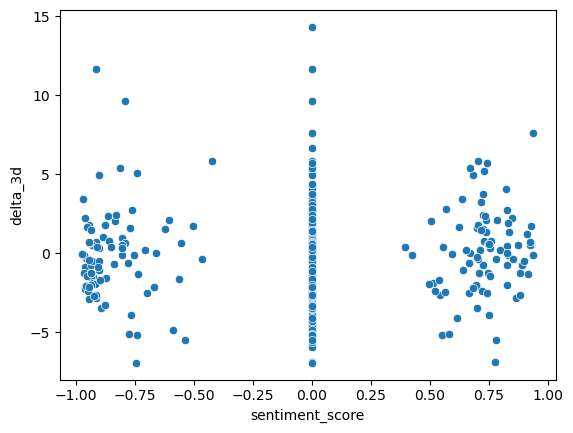

In [20]:
#plot the scatter sentiment_score against delta_3d
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=merged_df, x="sentiment_score", y="delta_3d")
plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler

# Create a new DataFrame 'standardized'
standardized = pd.DataFrame()

# Copy necessary columns from merged_df
standardized['date'] = merged_df['Date_merge']
standardized['day_of_week'] = merged_df['day_of_week']
standardized['month'] = merged_df['month']

# Standardize the 'delta_daily' column
standardized['delta_daily'] = StandardScaler().fit_transform(merged_df['delta_daily'].values.reshape(-1, 1))

# Calculate 'sentiment_negative' column based on 'sentiment_score'
standardized['sentiment_negative'] = merged_df['sentiment_negative'] * merged_df['sentiment_score']
standardized['sentiment_positive'] = merged_df['sentiment_positive'] * merged_df['sentiment_score']
standardized['sentiment_neutral'] = merged_df['sentiment_neutral'] * merged_df['sentiment_score']

# Standardize the 'sentiment_negative' column
standardized['sentiment_negative'] = StandardScaler().fit_transform(standardized['sentiment_negative'].values.reshape(-1, 1))
standardized['sentiment_positive'] = StandardScaler().fit_transform(standardized['sentiment_positive'].values.reshape(-1, 1))
standardized['sentiment_neutral'] = StandardScaler().fit_transform(standardized['sentiment_neutral'].values.reshape(-1, 1))


# Filter out rows with NaN values in the 'sentiment_negative' column
standardized = standardized.dropna(subset=['sentiment_negative' , "delta_daily"])

# reset index
standardized = standardized.reset_index(drop=True)

# Display the modified DataFrame
standardized


,date,day_of_week,month,delta_daily,sentiment_negative,sentiment_positive,sentiment_neutral
0,01-02-2022,Tuesday,February,-1.523805,1.598837,-0.536026,-1.076656
1,01-02-2022,Tuesday,February,-1.523805,-0.537542,-0.536026,0.951817
2,01-02-2022,Tuesday,February,-1.523805,-0.537542,1.852348,-1.076656
3,01-06-2021,Tuesday,June,-0.138697,1.709234,-0.536026,-1.076656
4,01-06-2021,Tuesday,June,-0.138697,-0.537542,-0.536026,1.021499
...,...,...,...,...,...,...,...
373,31-05-2023,Wednesday,May,1.116054,-0.537542,-0.536026,0.787079
374,31-05-2023,Wednesday,May,1.116054,1.778259,-0.536026,-1.076656
375,31-08-1999,Tuesday,August,0.954244,-0.537542,-0.536026,0.931206
376,31-10-2022,Monday,October,0.003141,-0.537542,-0.536026,0.621333


In [49]:
# ols regression model 

# delta_daily against sentiment_negative, sentiment_positive, sentiment_neutral and day_of_week

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the regression formula

# formula = "delta_daily ~ sentiment_negative + sentiment_positive + sentiment_neutral + day_of_week + month"

formula = "delta_daily ~ sentiment_negative + day_of_week"

# Define the model
model = smf.ols(formula=formula, data=standardized)

# Fit the model
results = model.fit()

# Print the results
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:            delta_daily   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.335
Date:                Sat, 02 Sep 2023   Prob (F-statistic):            0.00584
Time:                        12:11:56   Log-Likelihood:                -528.07
No. Observations:                 378   AIC:                             1068.
Df Residuals:                     372   BIC:                             1092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [27]:
# Bond prices

# Define the ticker symbol for the Eurozone bond you're interested in
bond_ticker = ["DAX"]

# Define the start and end dates for the data you want to fetch
start_date = "2000-01-01"
end_date = "2023-08-01"

# Fetch the bond price data using yfinance
bond_data = yf.download(bond_ticker, start=start_date, end=end_date)

# remove the 1st row for Date, and keep it in 0th row
bond_data.reset_index(inplace=True)

# keep only date and adjusted close columns
bond_data = bond_data[['Date','Adj Close']]
bond_data.columns = ['Date', 'bond_price']

# generate more variables
bond_data['b_delta_daily'] = bond_data['bond_price'].diff()
bond_data['b_delta_3d'] = bond_data['bond_price'].diff(3)
bond_data['b_delta_5d'] = bond_data['bond_price'].diff(5)
bond_data['b_delta_30d'] = bond_data['bond_price'].diff(30)
bond_data['b_3d_pp_change'] = bond_data['bond_price'].pct_change(3)

# Display the downloaded data
bond_data 

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_9079/2661862225.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_data['b_delta_daily'] = bond_data['bond_price'].diff()
/tmp/ipykernel_9079/2661862225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_data['b_delta_3d'] = bond_data['bond_price'].diff(3)
/tmp/ipykernel_9079/2661862225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Date,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change
0,2014-10-23,20.524279,NaN,NaN,NaN,NaN,NaN
1,2014-10-24,20.475510,-0.048769,NaN,NaN,NaN,NaN
2,2014-10-27,20.343826,-0.131683,NaN,NaN,NaN,NaN
3,2014-10-28,20.735619,0.391792,0.211340,NaN,NaN,0.010297
4,2014-10-29,20.865671,0.130053,0.390162,NaN,NaN,0.019055
...,...,...,...,...,...,...,...
2201,2023-07-25,30.100000,0.130001,-0.049999,-0.309999,1.268011,-0.001658
2202,2023-07-26,30.080000,-0.020000,-0.070000,-0.240000,0.866453,-0.002322
2203,2023-07-27,30.000000,-0.080000,0.030001,-0.150000,0.590784,0.001001
2204,2023-07-28,30.490000,0.490000,0.389999,0.340000,0.982948,0.012957


In [28]:
# merge bond and merged_df
merged_df = pd.merge(merged_df, bond_data, left_on='Date', right_on='Date', how='outer')
# create 3 day lagged percentage change
merged_df['b_delta_3d_pct_lag'] = merged_df['b_3d_pp_change'].shift(3)
merged_df['delta_3d_pct_lag'] = merged_df['3d_pp_change'].shift(3)
merged_df

,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,delta_3d,delta_5d,delta_30d,...,sentiment_neutral,sentiment_positive,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change,b_delta_3d_pct_lag,delta_3d_pct_lag
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,14.3172,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,2021-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,31.150692,0.658386,1.090830,1.319551,2.166845,0.036289,-0.003697,NaN
6509,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.720982,0.192863,0.041094,0.326971,-0.574852,0.001339,0.007830,NaN
6510,2022-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.842300,-0.114010,0.057957,-0.437037,1.339621,0.002248,-0.016633,NaN
6511,2023-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.802639,-0.097836,-0.088053,0.088051,1.653412,-0.003048,0.036289,NaN


In [113]:
merged_df.describe()

,Date,Indexvalue,delta_daily,delta_3d,delta_5d,delta_30d,3d_pp_change,sentiment_score,sentiment_negative,sentiment_neutral,sentiment_positive,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change,b_delta_3d_pct_lag,delta_3d_pct_lag
count,6472,6442.000000,6441.000000,6438.000000,6436.000000,6407.000000,6438.000000,420.000000,420.000000,420.000000,420.000000,2363.000000,2362.000000,2360.000000,2358.000000,2333.000000,2360.000000,2357.000000,6438.000000
mean,2011-08-15 05:05:42.645240832,23.745494,-0.000812,-0.002198,-0.001188,-0.117159,0.005630,0.834390,0.211905,0.573810,0.214286,24.707562,0.003771,0.015055,0.025226,0.137136,0.000881,0.000876,0.005630
min,1999-01-04 00:00:00,10.678300,-13.987300,-31.328600,-27.666400,-54.900100,-0.403941,0.394449,0.000000,0.000000,0.000000,15.713292,-2.268639,-3.506903,-4.961187,-9.587053,-0.175011,-0.175011,-0.403941
25%,2005-05-02 18:00:00,17.352175,-0.796700,-1.357775,-1.724875,-3.564600,-0.061544,0.767635,0.000000,0.000000,0.000000,21.853713,-0.154525,-0.254741,-0.298640,-0.699909,-0.010454,-0.010565,-0.061544
50%,2011-09-05 12:00:00,21.840200,-0.100400,-0.137300,-0.178650,-0.639700,-0.006937,0.866406,0.000000,1.000000,0.000000,24.553036,0.008644,0.029675,0.068186,0.235357,0.001183,0.001176,-0.006937
75%,2017-12-28 06:00:00,27.316325,0.663400,1.188250,1.443900,2.523200,0.057071,0.926595,0.000000,1.000000,0.000000,27.141617,0.184257,0.329349,0.400460,1.089788,0.013057,0.013048,0.057071
max,2023-08-21 00:00:00,87.512700,22.641500,31.859100,39.871200,71.191700,0.947828,0.972653,1.000000,1.000000,1.000000,32.657291,1.835562,2.723280,3.080296,5.618279,0.167343,0.167343,0.947828
std,NaN,9.302241,1.814967,2.984199,3.684632,7.285938,0.110118,0.115070,0.409145,0.495112,0.410815,3.636605,0.325765,0.550841,0.710288,1.672240,0.023749,0.023762,0.110118


In [114]:
# data with no nans if column is null
restricted_sample = merged_df[merged_df['sentiment'].notnull()]
restricted_sample.reset_index(inplace=True)
restricted_sample

,index,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,delta_3d,delta_5d,...,sentiment_neutral,sentiment_positive,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change,b_delta_3d_pct_lag,delta_3d_pct_lag
0,0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,14.3172,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,1999-01-11,V2TX,36.8411,11-01-1999,Monday,January,3.6115,11.6741,18.6378,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,6478,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,6479,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,6480,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,6481,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
restricted_sample.tail(20)

,index,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,delta_3d,delta_5d,...,sentiment_neutral,sentiment_positive,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change,b_delta_3d_pct_lag,delta_3d_pct_lag
400,6463,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,6464,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,6465,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,6466,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,6467,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,6468,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,6469,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,6470,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,6471,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,6472,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# run olx regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the regression formula
formula = "delta_3d_pct_lag ~ sentiment_score * sentiment_negative "

# Fit the regression
model = smf.ols(formula=formula, data=restricted_sample).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       delta_3d_pct_lag   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4566
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.713
Time:                        12:25:40   Log-Likelihood:                 256.86
No. Observations:                 377   AIC:                            -505.7
Df Residuals:                     373   BIC:                            -490.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [35]:
# Testing FinBERT again 

In [53]:
text = "Lehman's bankruptcy reverberated through global markets as its complex positions were unwound and investors worried which financial institutions could be next to fall. Within days, the insurer AIG and savings bank Washington Mutual were in trouble and the US government scrambled to put together a $700bn banking bailout package"

In [56]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

sentiment = pipe(text)
sentiment

[{'label': 'negative', 'score': 0.9238168597221375}]

In [ ]:
# plot daily change in index over time
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the daily change in the index and sentiment score
sns.lineplot(data=standardized, x="date", y="delta_daily", label="Delta Daily")
#sns.lineplot(data=standardized, x="date", y="sentiment_negative", label="Sentiment Negative")
#sns.lineplot(data=standardized, x="date", y="sentiment_positive", label="Sentiment Positive")
#sns.lineplot(data=standardized, x="date", y="sentiment_neutral", label="Sentiment Neutral")

# Set the title and axis labels
plt.title("Daily change in the VSTOXX index")
plt.xlabel("Date")

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.show()